In [5]:
import pyspark
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster('local')

sc.stop()
sc = SparkContext(conf = conf)
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [6]:
#cargar la base de datos
df = spark.read.option('header', 'true').csv('carpetas-de-investigacion-pgj-cdmx.csv', sep = ';')

In [7]:
df.printSchema()

root
 |-- Año: string (nullable = true)
 |-- Mes: string (nullable = true)
 |-- Alcaldía: string (nullable = true)
 |-- Categoría de delito: string (nullable = true)
 |-- Delito: string (nullable = true)
 |-- Agencia: string (nullable = true)
 |-- Unidad de investigación: string (nullable = true)
 |-- Fecha inicio: string (nullable = true)
 |-- Fiscalía: string (nullable = true)
 |-- Calle1: string (nullable = true)
 |-- Calle2: string (nullable = true)
 |-- Colonia: string (nullable = true)
 |-- Latitud: string (nullable = true)
 |-- Longitud: string (nullable = true)
 |-- Mes y año: string (nullable = true)
 |-- Geopoint: string (nullable = true)



In [8]:
df1 = df.select(['Alcaldía', 'Mes y año'])
df1 = df1.filter(df1['Alcaldía'] == 'IZTACALCO')#filtra por alcaldía

df1.show()

+---------+---------+
| Alcaldía|Mes y año|
+---------+---------+
|IZTACALCO|  2016-05|
|IZTACALCO|  2016-05|
|IZTACALCO|  2016-05|
|IZTACALCO|  2016-05|
|IZTACALCO|  2016-01|
|IZTACALCO|  2016-01|
|IZTACALCO|  2016-01|
|IZTACALCO|  2016-01|
|IZTACALCO|  2016-01|
|IZTACALCO|  2017-03|
|IZTACALCO|  2017-03|
|IZTACALCO|  2017-03|
|IZTACALCO|  2017-03|
|IZTACALCO|  2017-03|
|IZTACALCO|  2017-03|
|IZTACALCO|  2016-11|
|IZTACALCO|  2016-11|
|IZTACALCO|  2016-11|
|IZTACALCO|  2016-11|
|IZTACALCO|  2017-03|
+---------+---------+
only showing top 20 rows



In [9]:
time_df = df1.groupby("Mes y año").count()#agrupa por mes y año para contar delitos
time_df.show()

+---------+-----+
|Mes y año|count|
+---------+-----+
|  2018-10| 1031|
|  2017-09|  871|
|  2017-10|  943|
|  2016-02|  572|
|  2017-05|  800|
|  2018-06|  873|
|  2017-11|  909|
|  2018-03|  939|
|  2017-03|  777|
|  2018-02|  853|
|  2016-12|  686|
|  2017-08|  888|
|  2016-09|  744|
|  2016-03|  676|
|  2017-06|  789|
|  2016-10|  730|
|  2017-02|  667|
|  2017-04|  697|
|  2018-05|  904|
|  2018-08| 1027|
+---------+-----+
only showing top 20 rows



In [30]:
import pandas as pd

time_pd = time_df.toPandas()#importa el dataframe a pandas
time_pd.set_index('Mes y año', inplace = True)#cambia índice por columna mes y año
time_pd.head()

,count
Mes y año,
2018-10,1031
2017-09,871
2017-10,943
2016-02,572
2017-05,800


In [31]:
time_pd = time_pd.sort_values(by = "Mes y año", ascending = True)
time_pd.drop('01/2019', inplace = True)#quita fila 01/2019 pues mete ruido al ser sólo un delito
time_pd.drop('feb-19', inplace = True)
time_pd.head()

,count
Mes y año,
2016-01,633
2016-02,572
2016-03,676
2016-04,768
2016-05,705


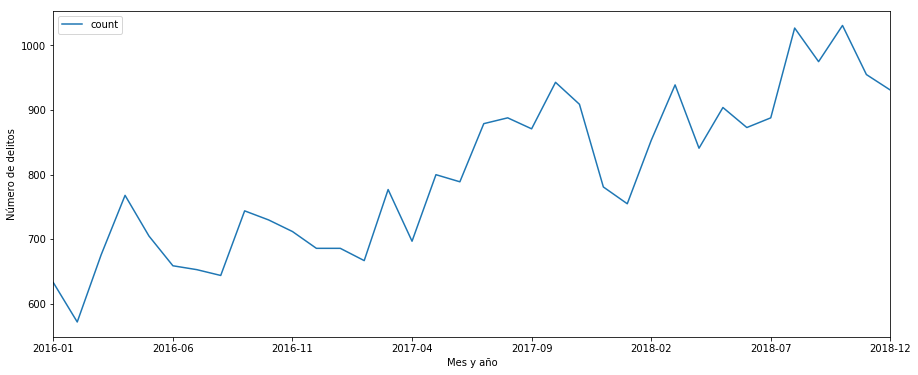

In [32]:
import matplotlib.pyplot as plt

time_pd.plot(figsize = (15, 6))
plt.ylabel('Número de delitos')
plt.show()

In [33]:
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
#from statsmodels import api as sm
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings('ignore')
p = q = range(0, 4)#define orden p y q del modelo
pq = list(itertools.product(p, q))#lista de posibles combinaciones de p y q
print("Examples of parameter combinations for ARMA")
print("ARMA {}".format(pq[1]))
print("ARMA {}".format(pq[2]))
print("ARMA {}".format(pq[3]))

Examples of parameter combinations for ARMA
ARMA (0, 1)
ARMA (0, 2)
ARMA (0, 3)


In [35]:
time_pd.index = pd.DatetimeIndex(time_pd.index)#cambia índice del dataframe a un índice temporal

#muestra el criterio de información Akaike
#es un estimador relativo a la calidad de modelos estadísticos
for param in pq:
    try:
        mod = ARMA(time_pd, order = param)
        
        results_test = mod.fit()
        #muestra resultados y busca el de menor valor
        print("ARMA{}: - AIC:{}".format(param, results_test.aic))
    except:
        continue

ARMA(0, 0): - AIC:450.9697869368542
ARMA(0, 1): - AIC:431.4524498197224
ARMA(0, 2): - AIC:422.6253280725354
ARMA(0, 3): - AIC:420.62685028287126
ARMA(1, 0): - AIC:411.32234184576174
ARMA(1, 1): - AIC:747.751809595002
ARMA(1, 2): - AIC:467.30844581323373
ARMA(2, 0): - AIC:412.4686805641833
ARMA(2, 1): - AIC:413.5805024398938
ARMA(2, 2): - AIC:419.1222144518083
ARMA(3, 0): - AIC:414.2513680567587
ARMA(3, 1): - AIC:415.51979729115476
ARMA(3, 2): - AIC:413.865113678315


In [36]:
model = ARMA(time_pd, order = (1, 0))#con el menor valor de aic, ajusta modelo a los datos
results = model.fit()
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:                  count   No. Observations:                   36
Model:                     ARMA(1, 0)   Log Likelihood                -202.661
Method:                       css-mle   S.D. of innovations             66.225
Date:                Sat, 06 Apr 2019   AIC                            411.322
Time:                        13:41:17   BIC                            416.073
Sample:                    01-01-2016   HQIC                           412.980
                         - 12-01-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         796.6610     62.825     12.681      0.000     673.526     919.796
ar.L1.count     0.8461      0.088      9.614      0.000       0.674       1.019
                                    Roots       

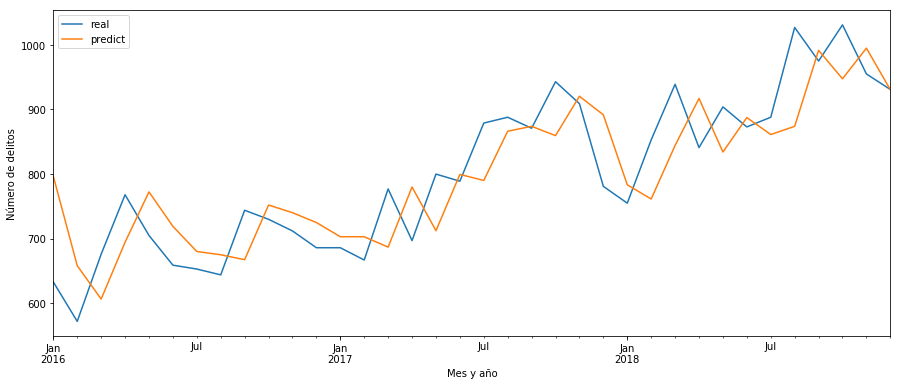

In [37]:
#generamos la predicción
pred_future = results.predict(start = pd.to_datetime('2016-01-01'), end = pd.to_datetime('2018-12-01'), dynamic = False)

#graficamos la predicción junto con los valores reales
time_pd.plot(figsize = (15, 6), label = 'datos')
pred_future.plot(label = 'predict')
plt.ylabel('Número de delitos')

L = plt.legend()
L.get_texts()[0].set_text('real')

ARIMA

In [ ]:
import numpy as np

ts = time_pd['count']#nuevo dataframe a partir de columna count
ts.head()
ts_log = np.log(ts)#cambiar escala a logarítmica